# PCB_DEFECT_DETECTION
Dataset: Mixed Data with Augmented PCB boards and 10 samples of external data

Addn data source: https://www.kaggle.com/datasets/frettapper/micropcb-images![image.png](attachment:image.png)

Number of existing datapoints: 500
Number of new datapoints: 10
Epoch 1/50
2/2 [==============================] - 15s 5s/step - loss: 0.6934 - val_loss: 0.6929
Epoch 2/50
2/2 [==============================] - 11s 5s/step - loss: 0.6928 - val_loss: 0.6925
Epoch 3/50
2/2 [==============================] - 12s 5s/step - loss: 0.6923 - val_loss: 0.6914
Epoch 4/50
2/2 [==============================] - 11s 5s/step - loss: 0.6910 - val_loss: 0.6890
Epoch 5/50
2/2 [==============================] - 11s 4s/step - loss: 0.6885 - val_loss: 0.6851
Epoch 6/50
2/2 [==============================] - 11s 5s/step - loss: 0.6844 - val_loss: 0.6795
Epoch 7/50
2/2 [==============================] - 11s 4s/step - loss: 0.6789 - val_loss: 0.6725
Epoch 8/50
2/2 [==============================] - 12s 5s/step - loss: 0.6718 - val_loss: 0.6642
Epoch 9/50
2/2 [==============================] - 11s 4s/step - loss: 0.6632 - val_loss: 0.6555
Epoch 10/50
2/2 [==============================] - 10s 4s/step - loss: 0

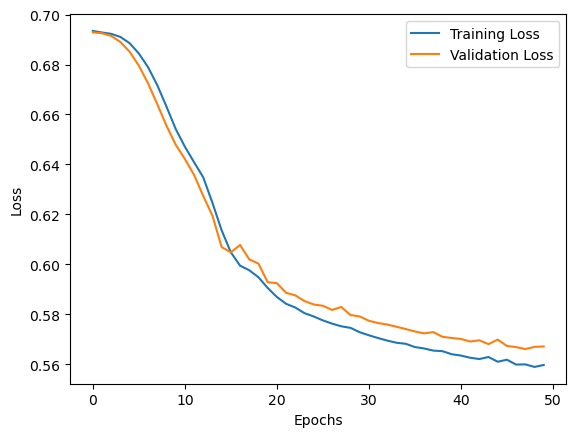

4/4 [==============================] - 1s 154ms/step
Accuracy: 0.8795333281159401


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from sklearn.model_selection import train_test_split

# Function to load and preprocess images from multiple folders
def load_processed_images(folder_paths, image_size=(100, 100)):
    images = []  # Initialize an empty list to store the processed images

    # Iterate over all folder paths
    for folder_path in folder_paths:
        # Iterate over all files found in the current folder path
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)  # Create the full image path
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale mode

            if img is not None:  # Check if the image was successfully read
                img = cv2.resize(img, image_size)  # Resize the image to the specified size
                images.append(img)  # Add the processed image to the list

    # Convert the list of images to a numpy array and return it
    return np.array(images)

# Define paths to existing and additional dataset folders
existing_dataset_folder_path = r'R:\SIEMENS_Intern\PCB_augmented'  # Existing dataset folder
additional_dataset_folder_path = r'R:\SIEMENS_Intern\pcb_net_2'  # Additional dataset folder

# Combine existing and additional dataset paths
dataset_folder_paths = [existing_dataset_folder_path, additional_dataset_folder_path]

# Load and preprocess images from both dataset folders
processed_images = load_processed_images(dataset_folder_paths)

# Count the number of datapoints in existing and new files
num_existing_datapoints = len(os.listdir(existing_dataset_folder_path))
num_new_datapoints = len(os.listdir(additional_dataset_folder_path))

print(f"Number of existing datapoints: {num_existing_datapoints}")
print(f"Number of new datapoints: {num_new_datapoints}")

# Split the processed images into training and validation sets
X_train, X_val = train_test_split(processed_images, test_size=0.2, random_state=42)

# Normalize the images to have values between 0 and 1
X_train = X_train.astype('float32') / 255.
X_val = X_val.astype('float32') / 255.

# Reshape images for the CNN
X_train = np.expand_dims(X_train, axis=-1)  # Adds a channel dimension at the end for the training set
X_val = np.expand_dims(X_val, axis=-1)      # Adds a channel dimension at the end for the validation set

# Define the autoencoder model
def build_autoencoder(input_shape):
    model = Sequential([
        # Encoder Part
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(8, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2), padding='same'),

        # Decoder Part
        Conv2D(8, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        UpSampling2D((2, 2)),
        Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')
    ])
    return model

# Build the autoencoder model
input_shape = X_train.shape[1:]
model = build_autoencoder(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
history = model.fit(X_train, X_train, epochs=50, batch_size=256, validation_data=(X_val, X_val))

# Visualize training history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate accuracy
def calculate_accuracy(model, X_val):
    # Predict reconstruction for validation set
    reconstructed_images = model.predict(X_val)
    # Compute binary cross-entropy loss for each image
    binary_crossentropy = np.mean(np.abs(X_val - reconstructed_images))
    # Calculate accuracy (1 - binary cross-entropy)
    accuracy = 1 - binary_crossentropy
    return accuracy

accuracy = calculate_accuracy(model, X_val)
print(f"Accuracy: {accuracy}")


4/4 [==============================] - 1s 152ms/step
Validation Accuracy: 0.81


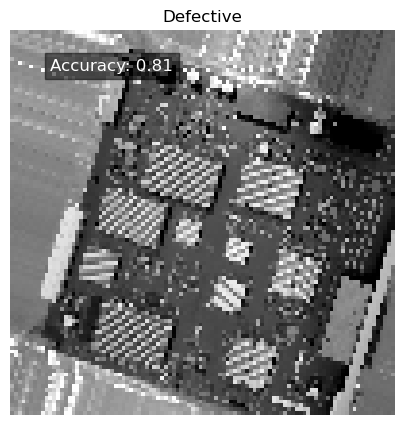

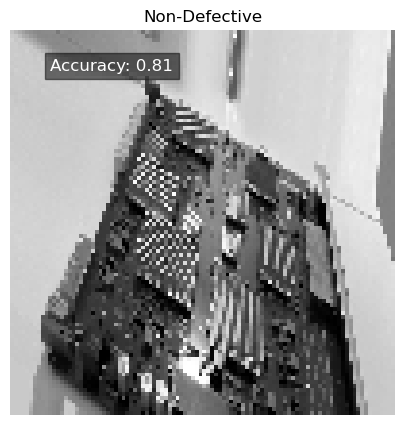

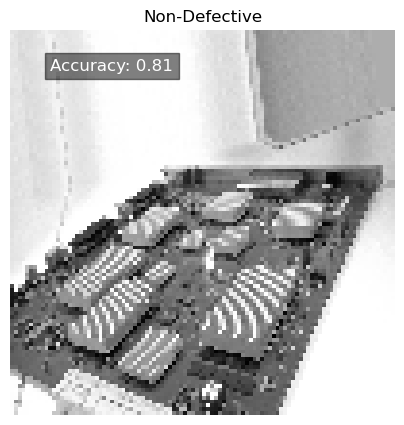

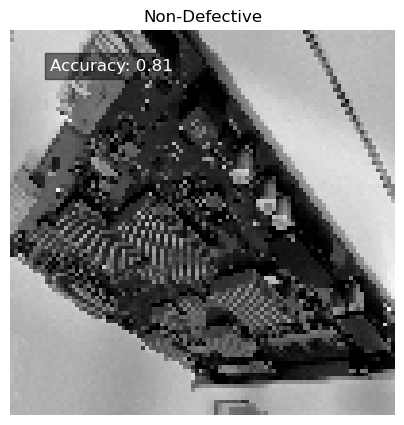

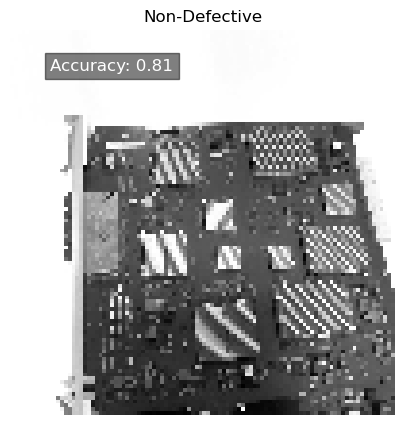

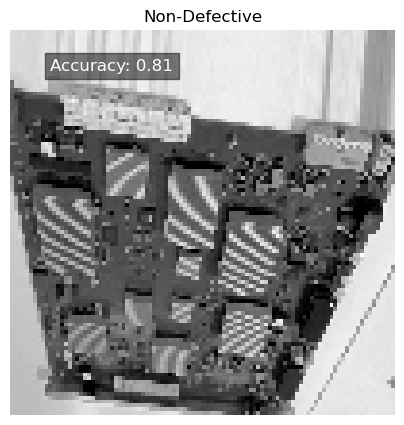

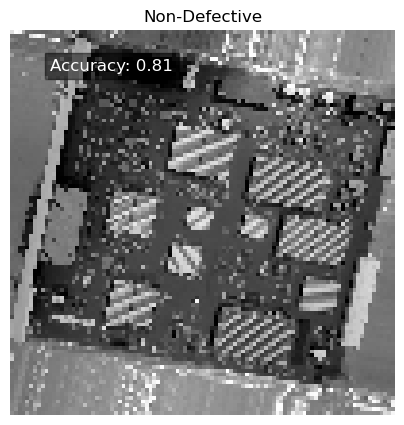

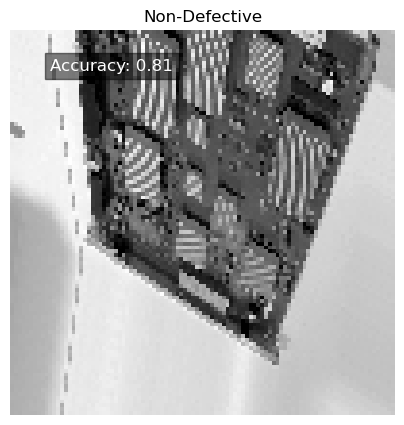

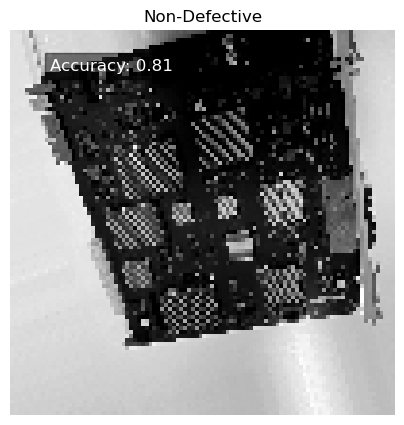

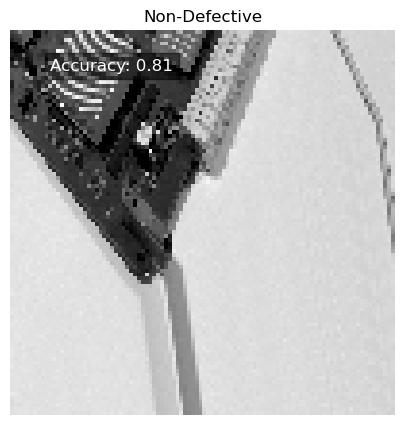

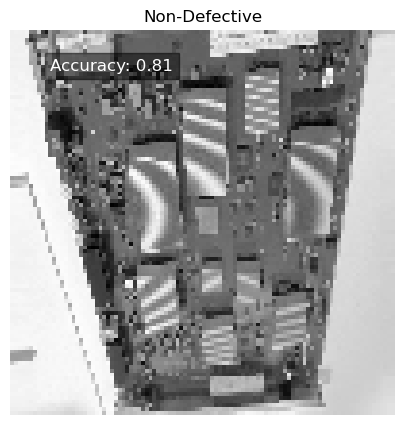

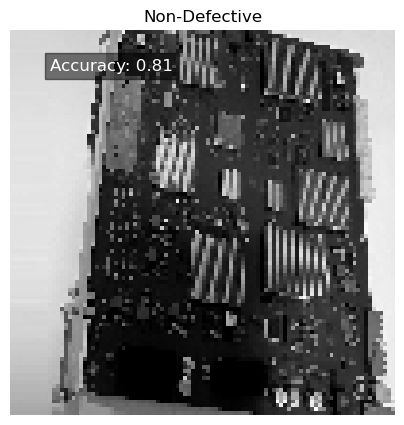

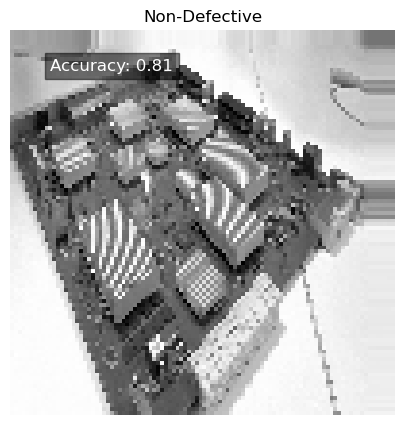

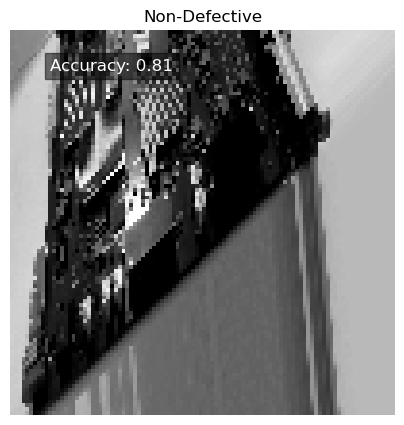

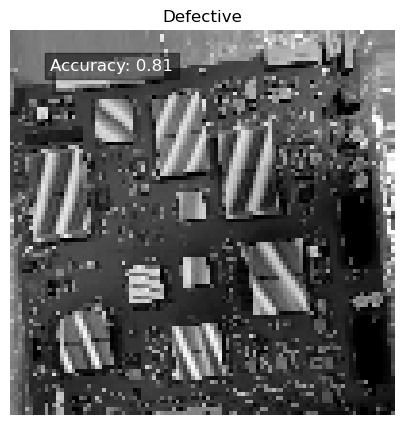

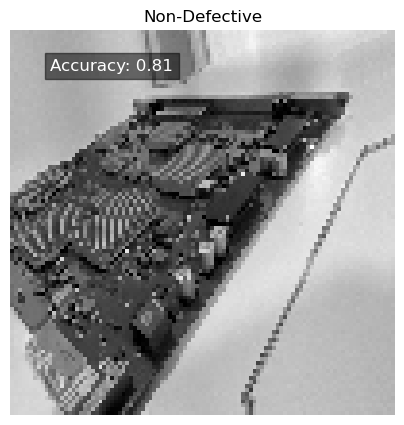

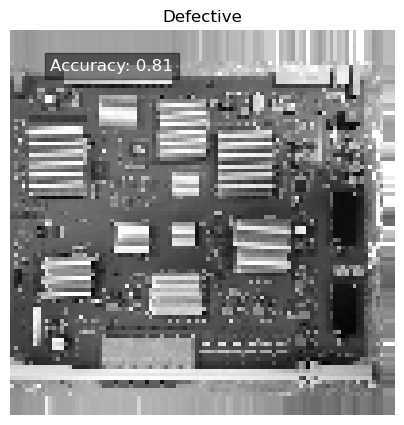

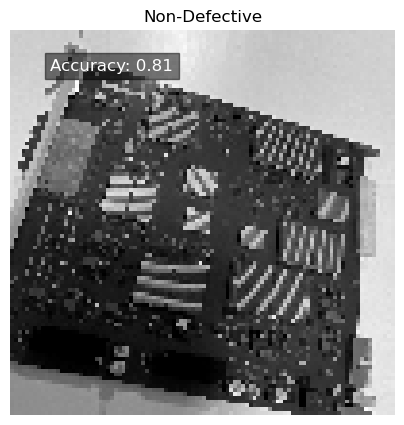

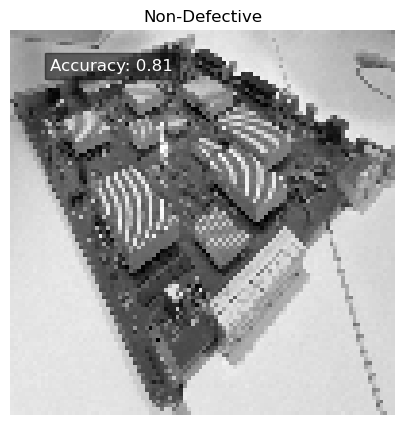

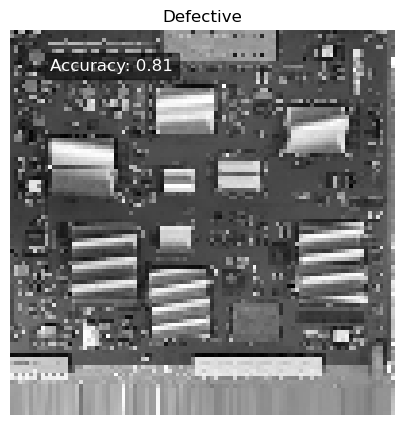

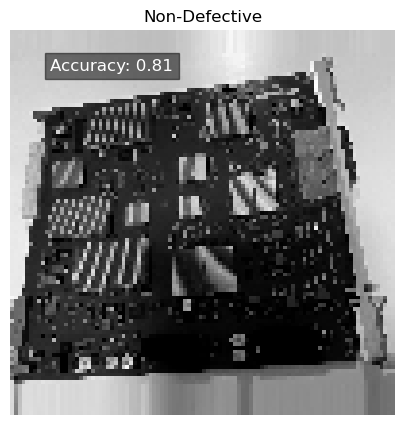

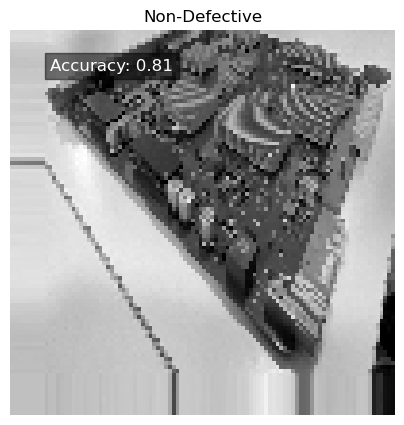

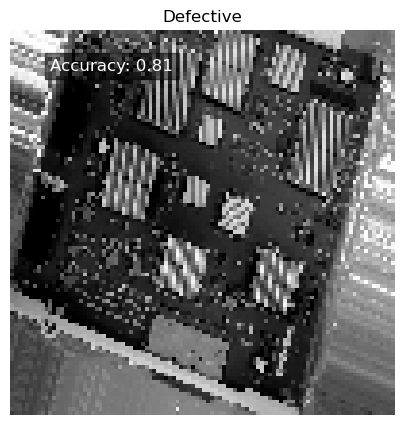

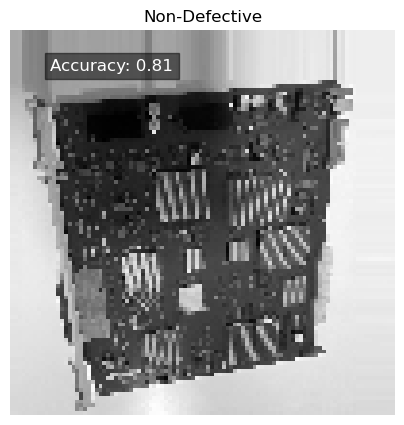

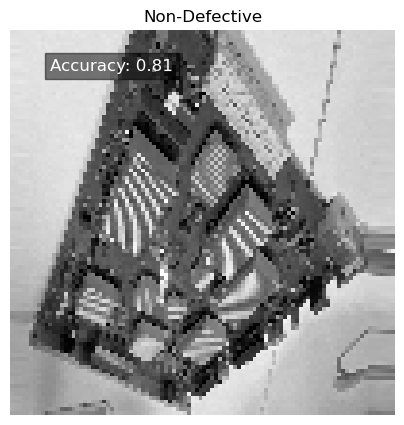

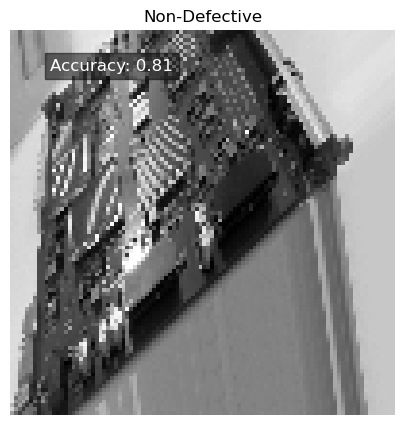

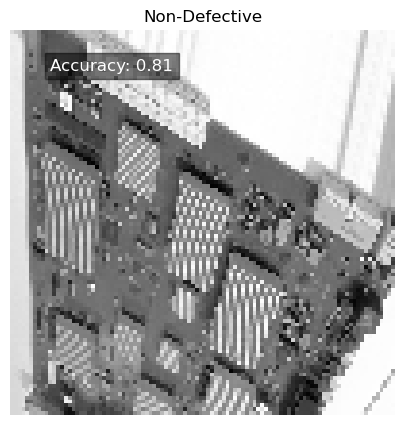

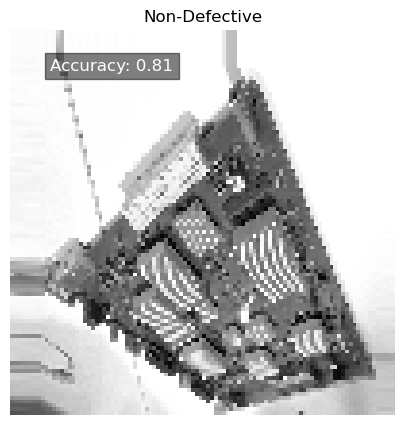

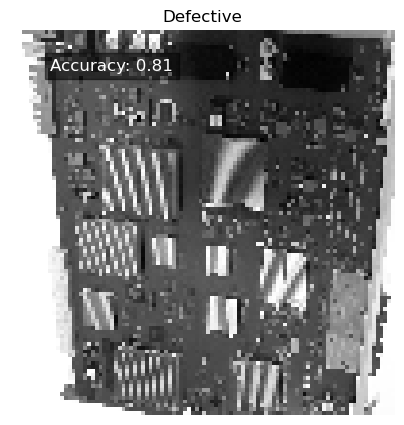

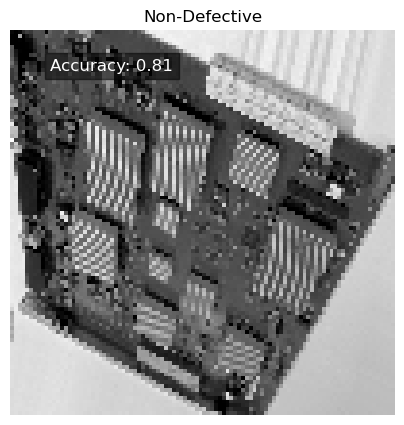

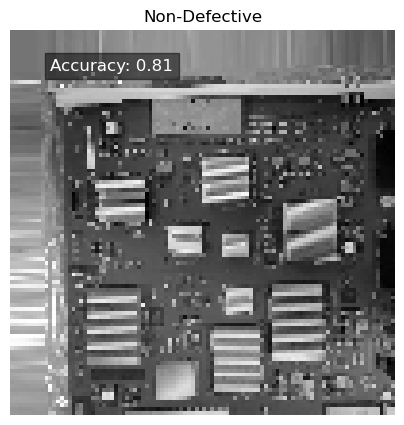

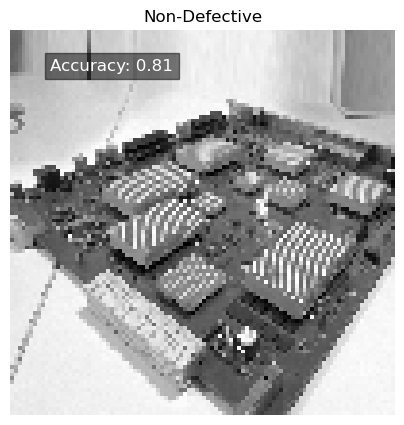

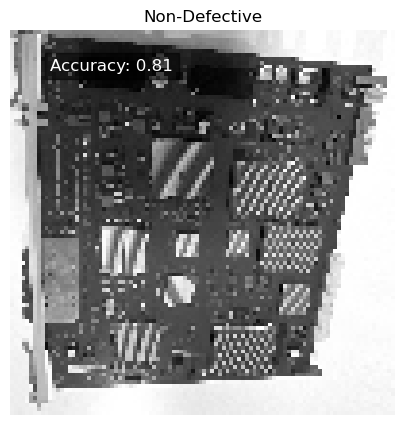

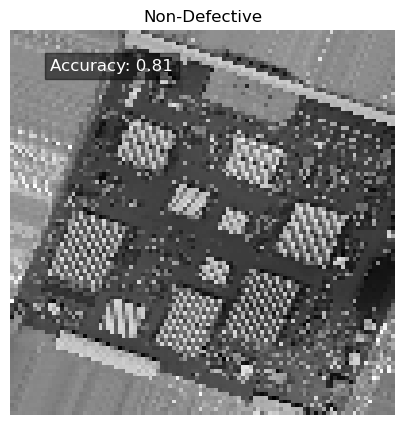

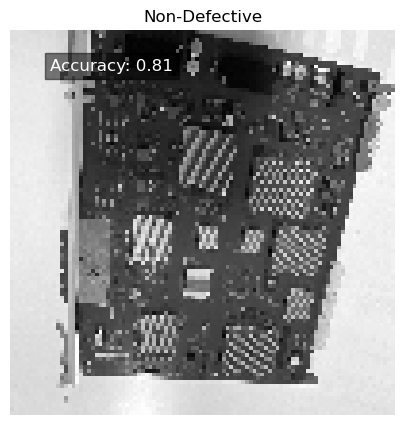

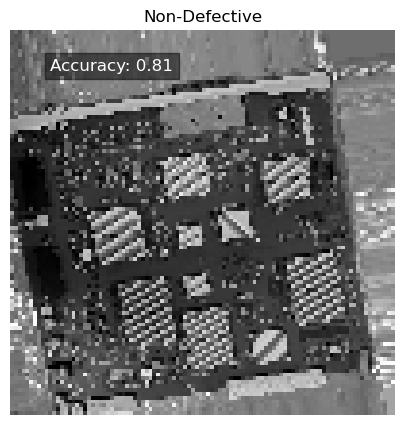

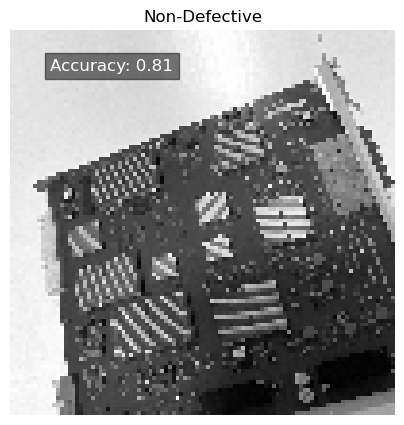

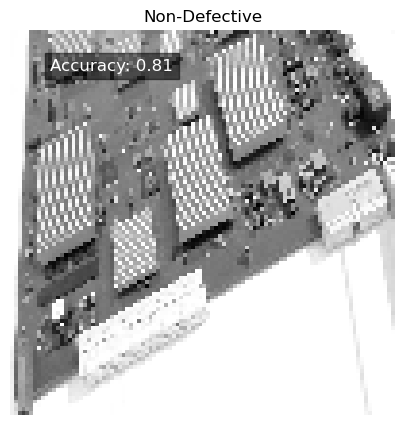

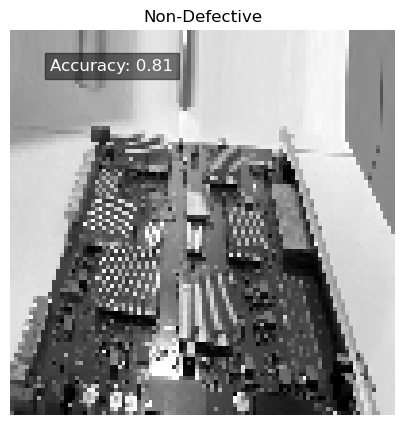

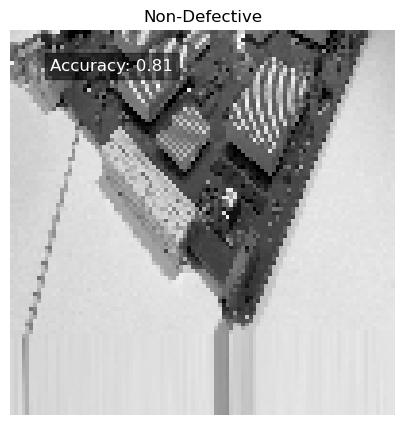

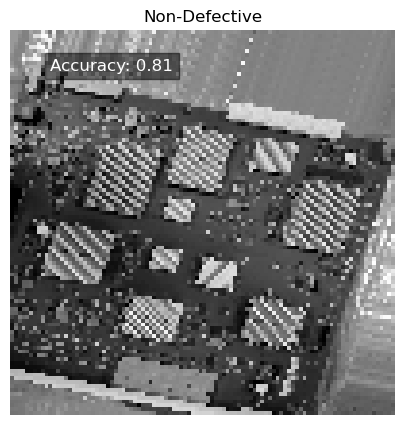

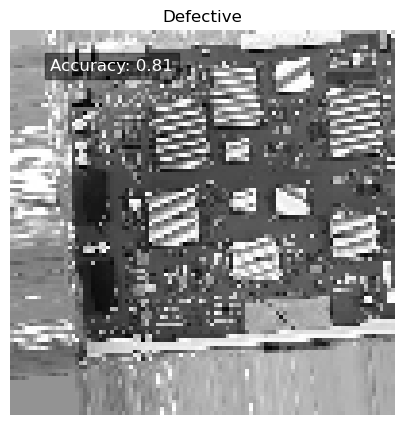

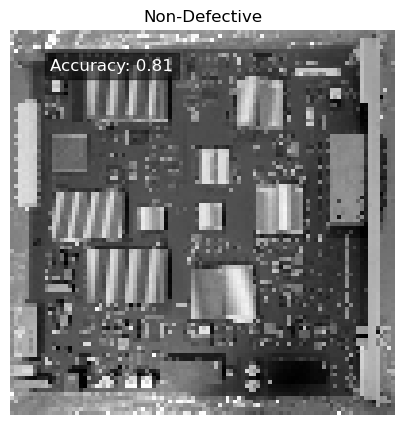

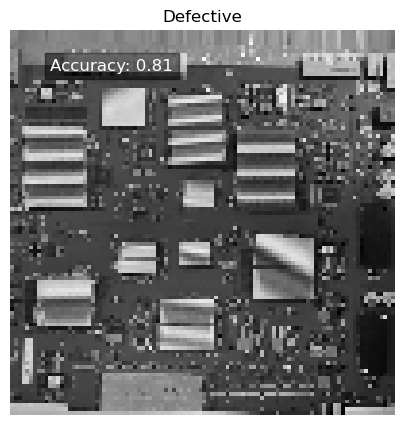

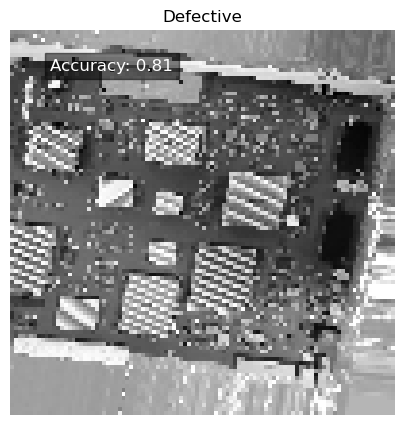

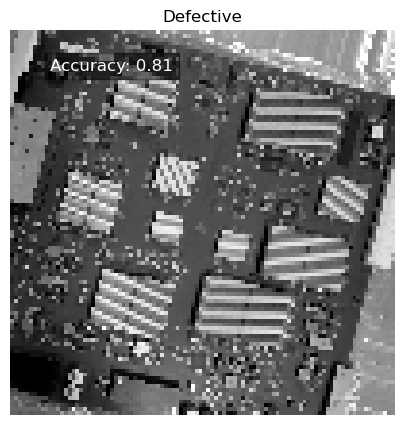

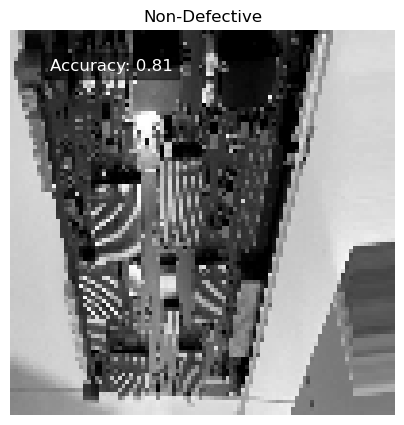

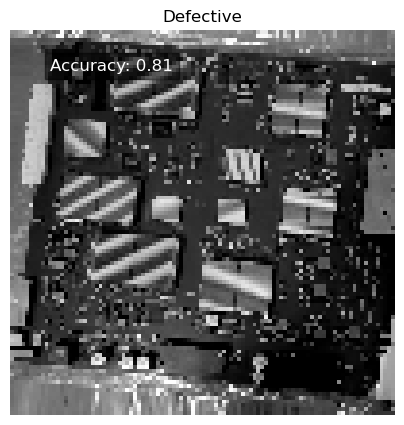

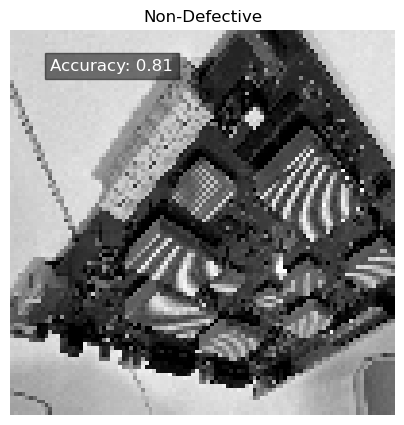

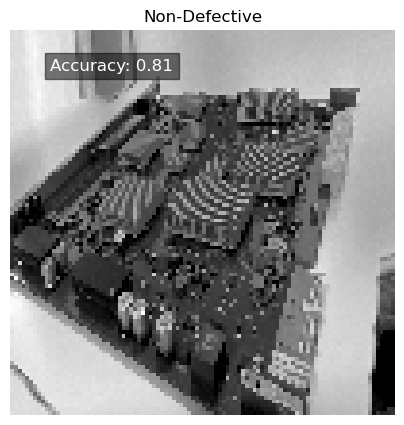

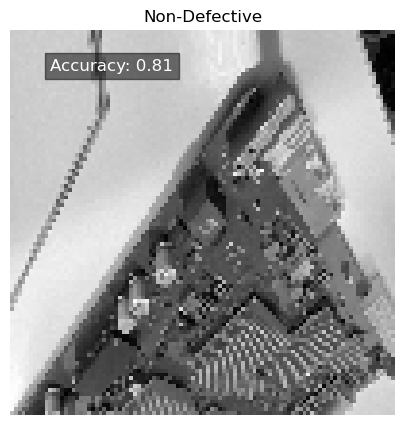

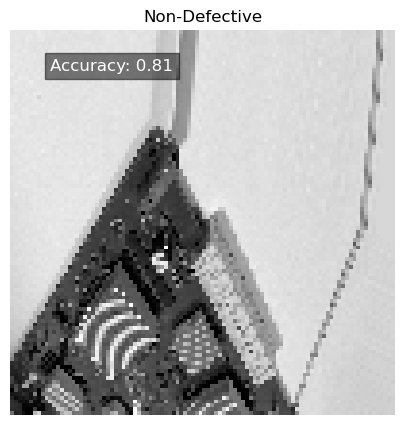

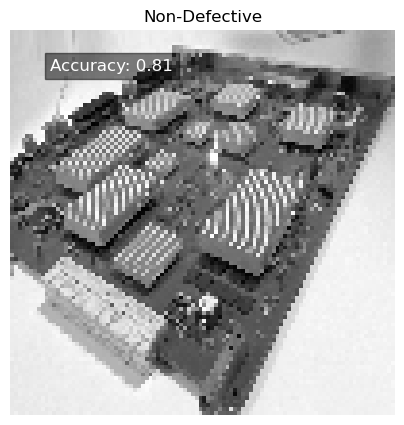

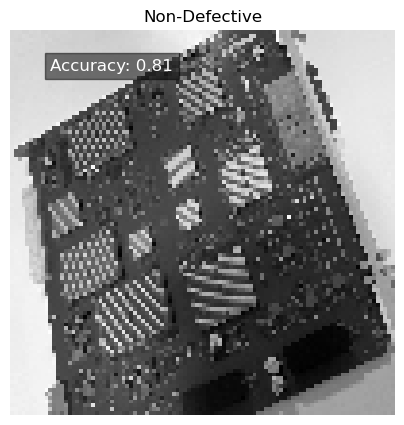

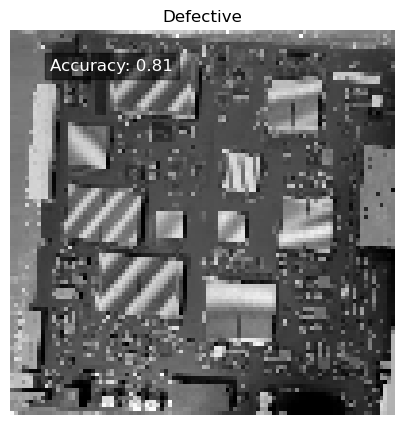

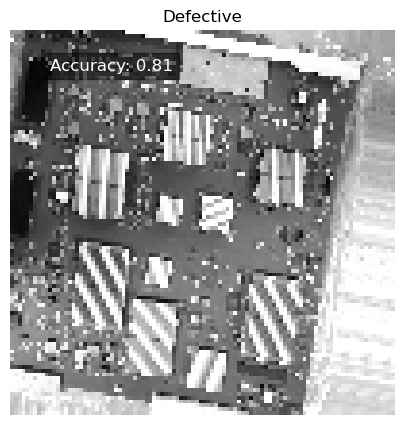

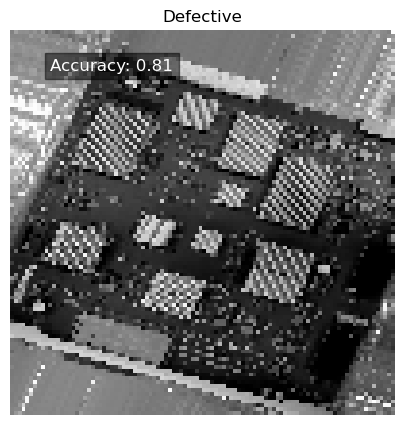

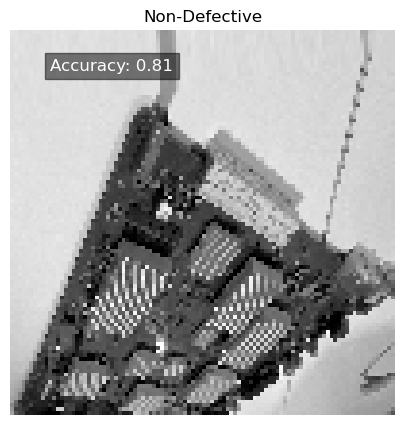

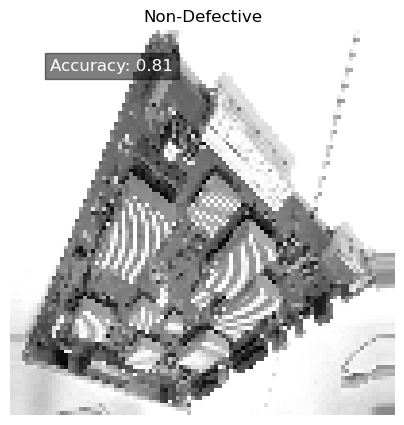

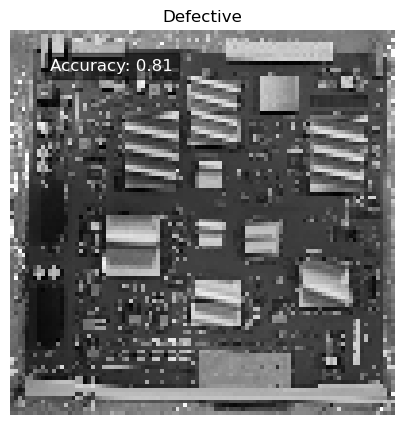

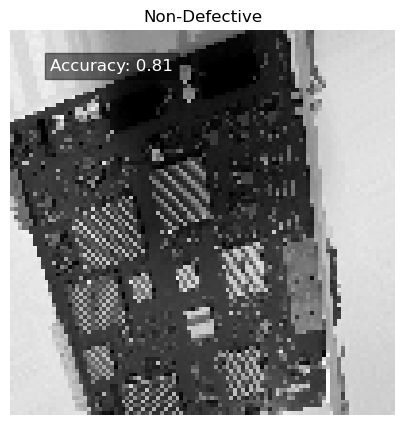

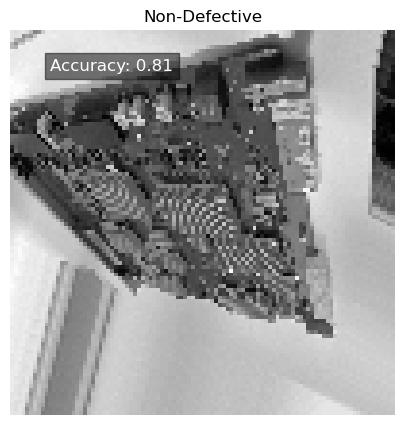

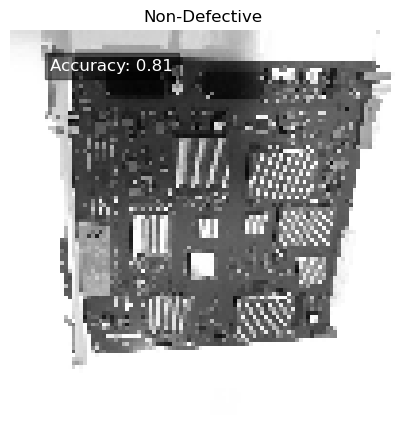

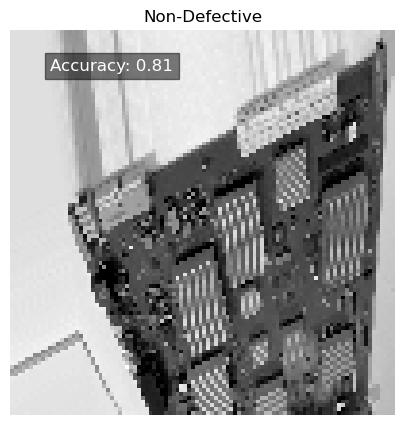

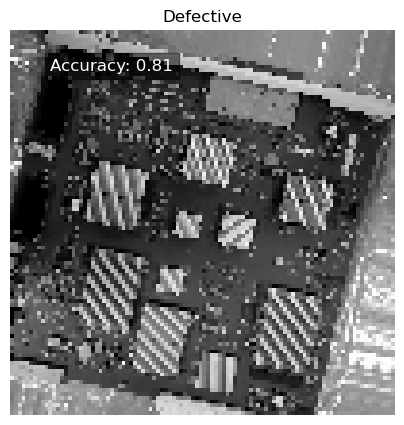

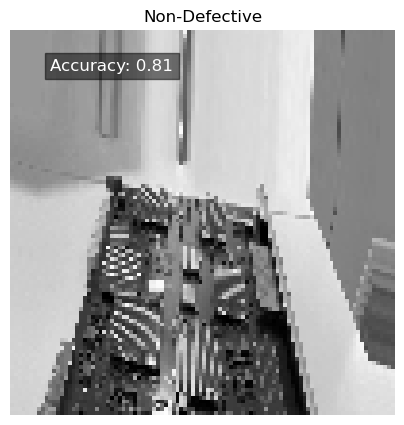

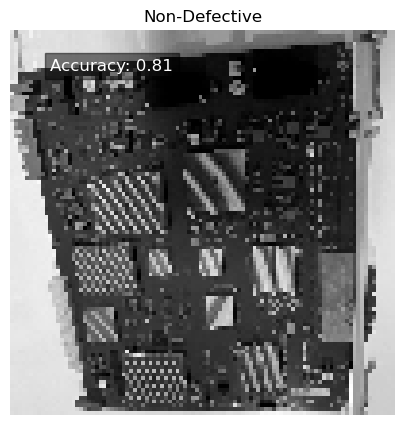

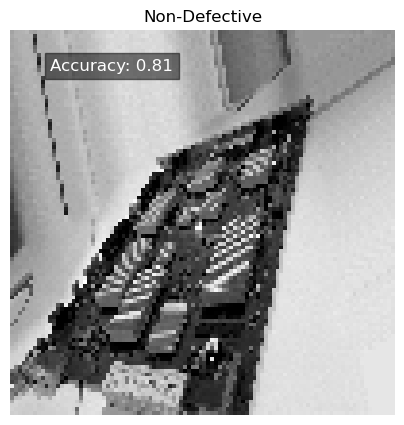

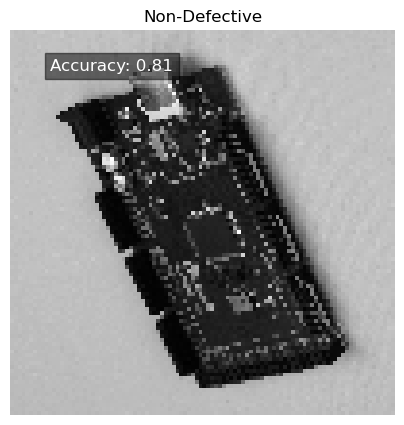

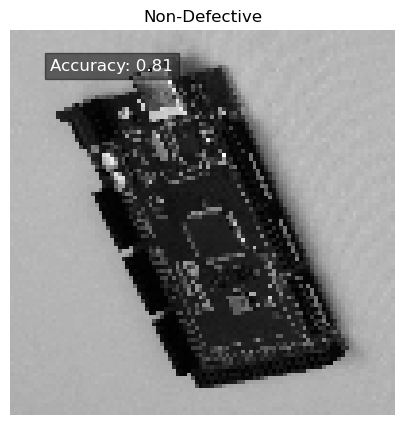

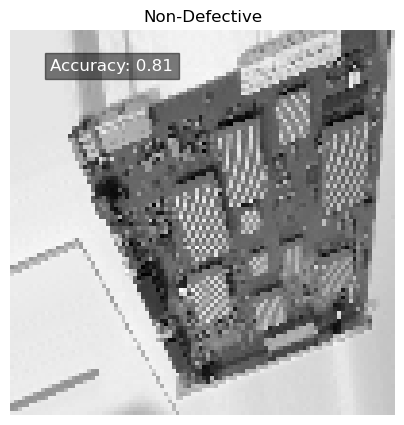

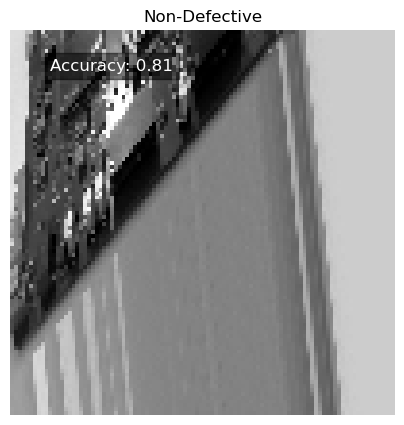

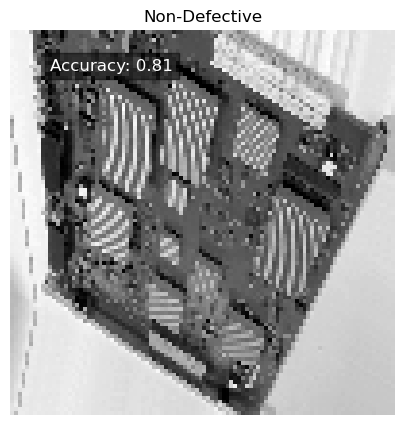

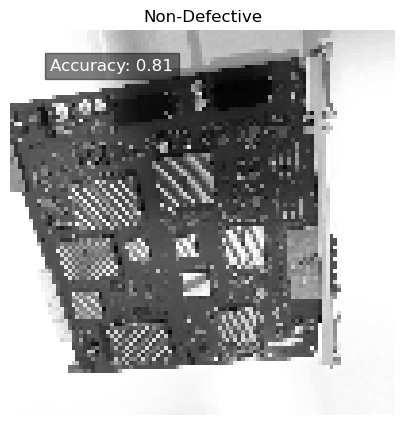

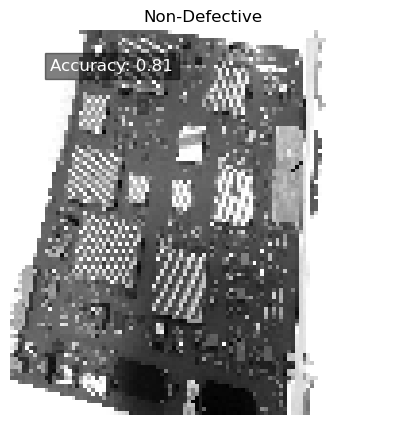

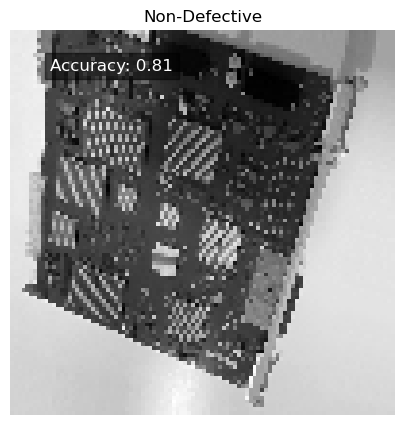

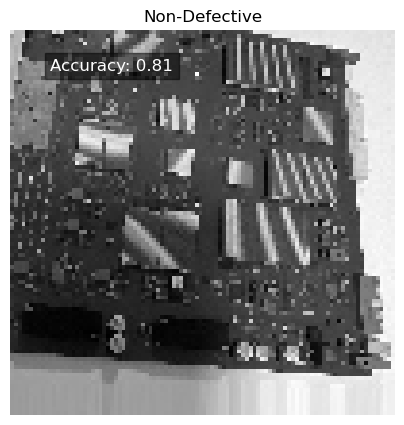

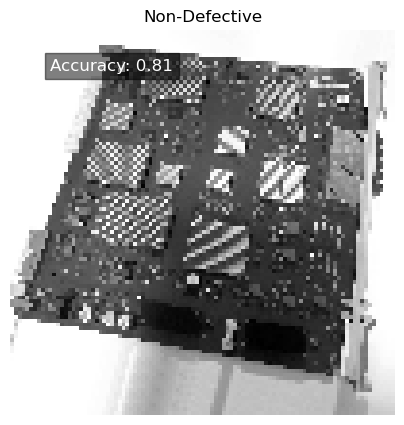

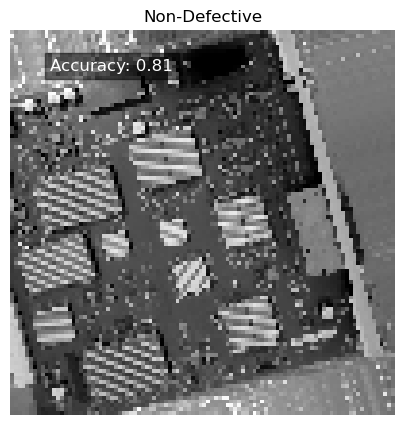

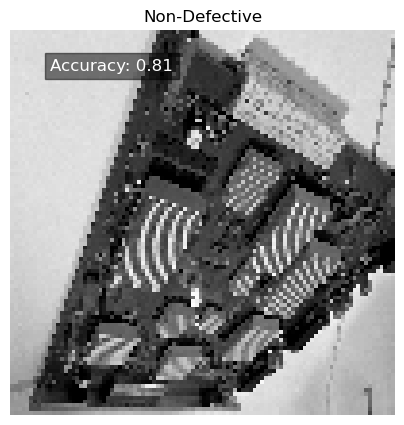

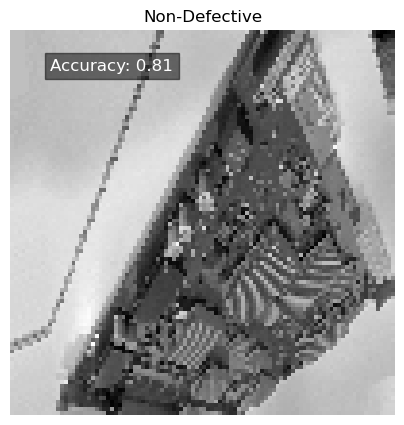

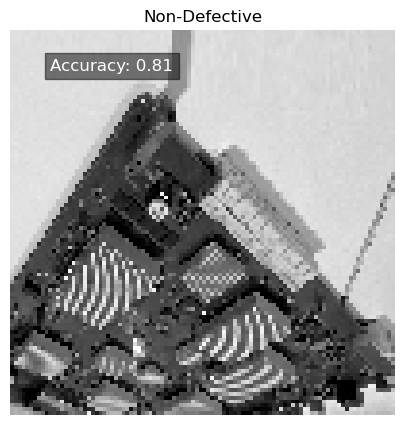

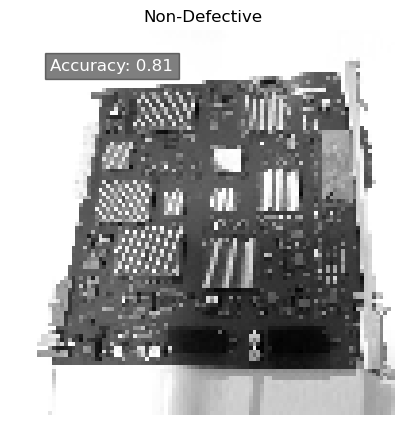

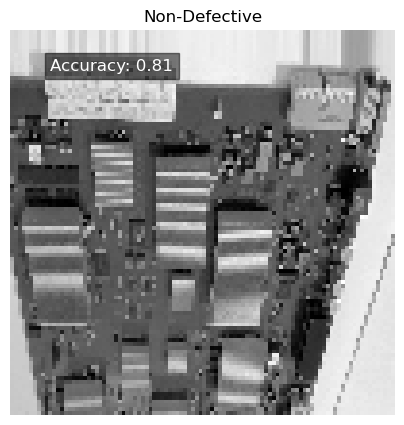

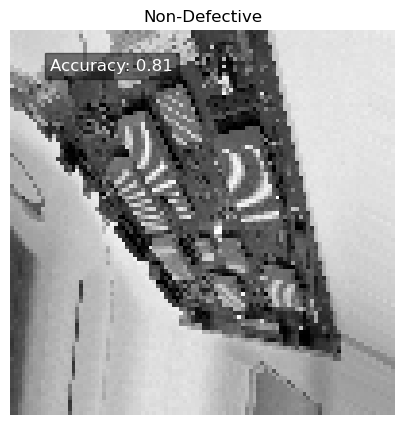

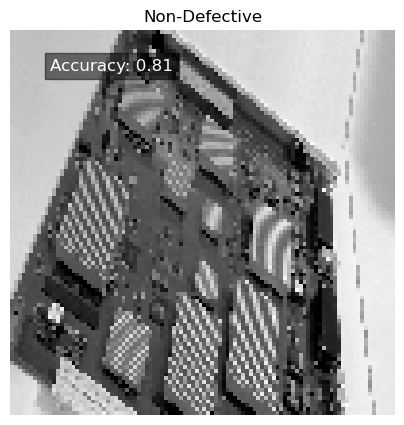

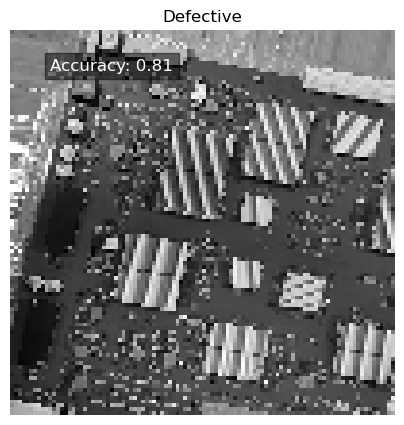

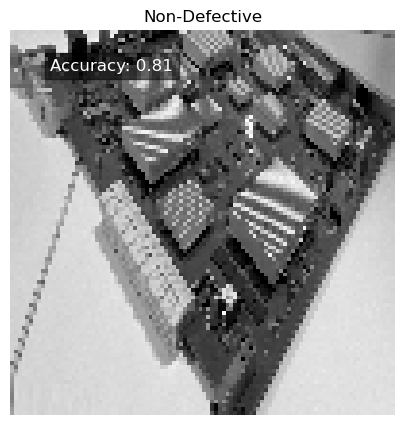

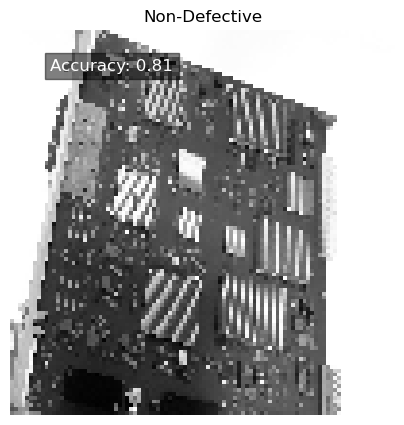

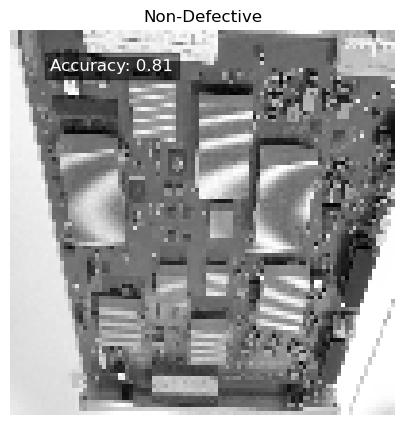

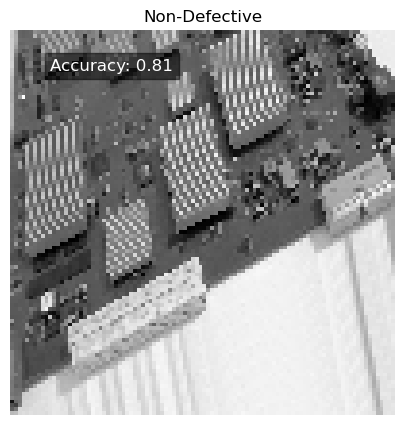

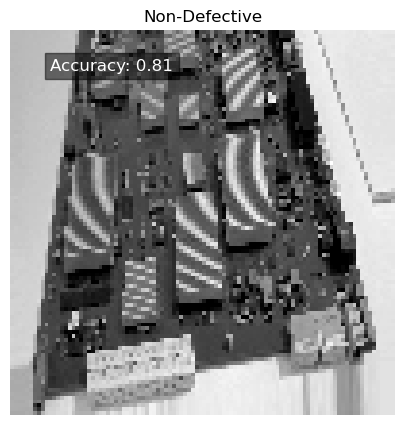

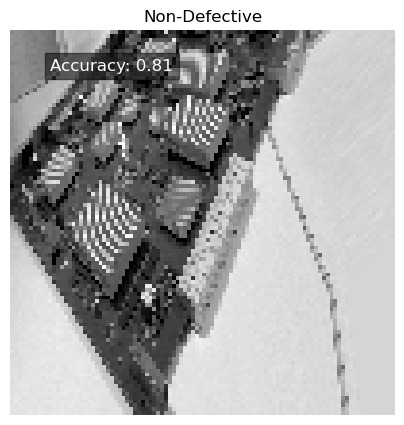

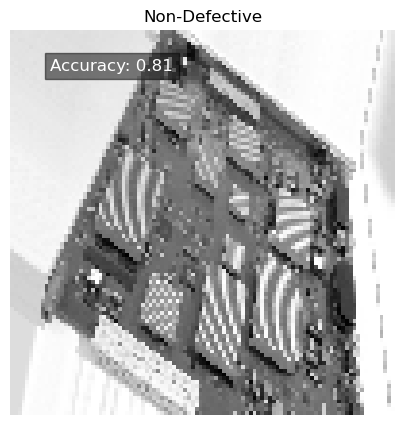

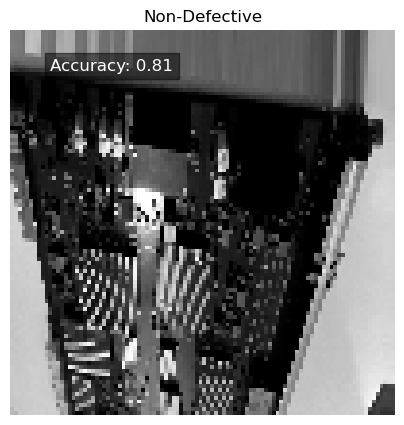

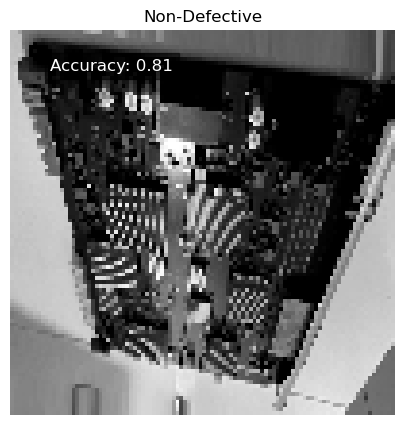

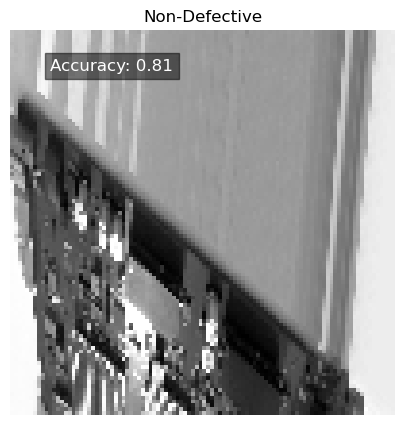

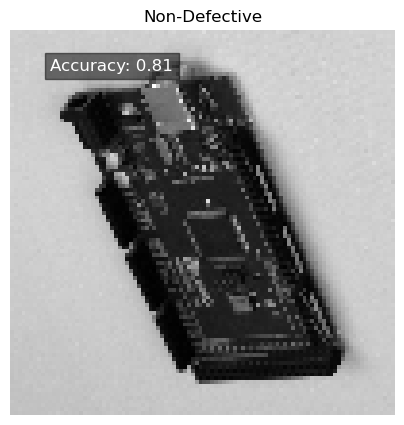

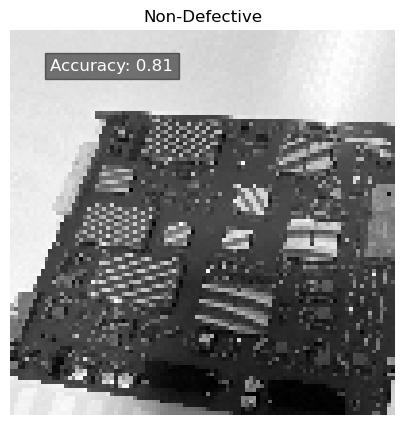

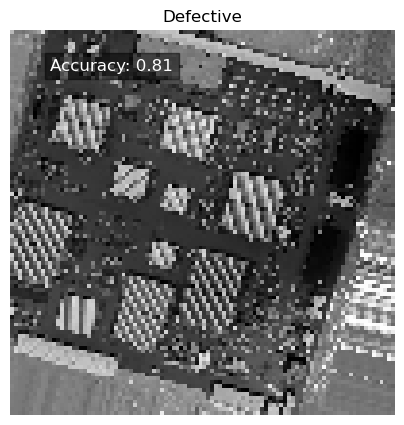

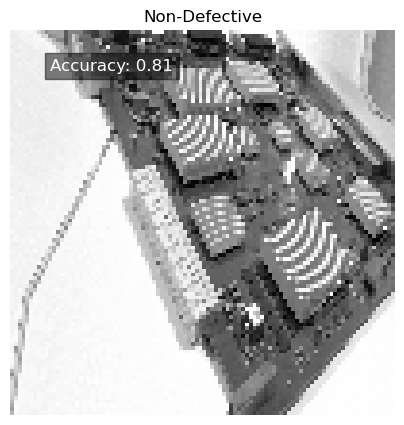

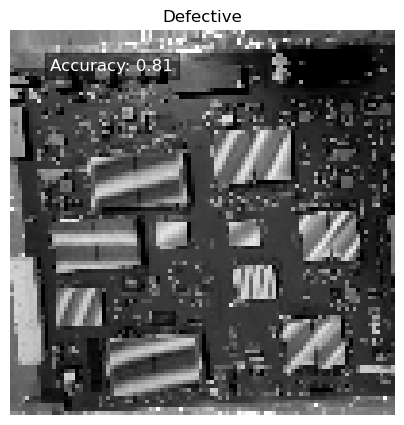

In [2]:
# Predict anomalies on validation set
reconstructed_val = model.predict(X_val)
errors_val = np.mean(np.abs(X_val - reconstructed_val), axis=(1,2,3))
threshold_val = np.mean(errors_val) + np.std(errors_val)  # Simple thresholding strategy
anomalies_val = errors_val > threshold_val

# Display images with labels
def display_image_with_label_and_accuracy(img, is_anomaly, accuracy):
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')  # Assuming img is in grayscale
    plt.title(f"{'Defective' if is_anomaly else 'Non-Defective'}")
    plt.text(10, 10, f'Accuracy: {accuracy:.2f}', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
    plt.axis('off')
    plt.show()

# Calculate accuracy
accuracy_val = np.mean(~anomalies_val)
print(f"Validation Accuracy: {accuracy_val:.2f}")

# Display images with labels and accuracy
for img, is_anomaly in zip(X_val.squeeze(), anomalies_val):
    display_image_with_label_and_accuracy(img, is_anomaly, accuracy_val)
